In [ ]:
import math
import torch
import torch.utils.benchmark
import matplotlib.pyplot as plt
from tqdm import tqdm

torch.backends.cuda.matmul.allow_tf32 = False
torch.backends.cudnn.allow_tf32 = False
torch._dynamo.config.cache_size_limit = 100
torch.set_default_device(torch.device("cuda:1"))

In [ ]:
@torch.compile(dynamic=True)
def ortho_QR(G: torch.Tensor):
    """Orthogonalize matrix using QR decomposition"""
    Q, R = torch.linalg.qr(G)
    return Q


@torch.compile(dynamic=True)
def _chol_qr_tall_skinny(A_bf16: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor]:
    """Mixed‑precision Cholesky QR for n ≫ m (tall‑skinny)."""
    assert A_bf16.dtype == torch.bfloat16
    G_fp32: torch.Tensor = torch.matmul(A_bf16.transpose(-2, -1), A_bf16).float()
    R_fp32: torch.Tensor = torch.linalg.cholesky(G_fp32).transpose(-2, -1).contiguous()
    Q_fp32: torch.Tensor = torch.linalg.solve_triangular(
        R_fp32, A_bf16.float().T, upper=True
    ).T
    return Q_fp32.to(torch.bfloat16), R_fp32.to(torch.bfloat16)


@torch.compile(dynamic=True)
def ortho_qr_bf16(
    A: torch.Tensor, *, reduced: bool = True
) -> tuple[torch.Tensor, torch.Tensor]:
    """QR decomposition that prefers bf16 compute on GPUs."""
    if A.dtype != torch.bfloat16:
        A = A.to(torch.bfloat16)
    n, m = A.shape[-2:]
    tall_skinny = n >= 2 * m and A.is_contiguous()
    if tall_skinny and A.is_cuda:
        Q, R = _chol_qr_tall_skinny(A)
    else:
        Q32, R32 = torch.linalg.qr(A.float(), mode="reduced" if reduced else "complete")
        Q, R = Q32.to(torch.bfloat16), R32.to(torch.bfloat16)
    if not reduced and n > m:
        pad_cols = n - m
        zero_pad = torch.zeros(*Q.shape[:-1], pad_cols, dtype=Q.dtype, device=Q.device)
        Q = torch.cat([Q, zero_pad], dim=-1)
    return Q, R


@torch.compile(dynamic=True)
def ortho_CQR1(G):
    """Orthogonalize with Cholesky QR (1 iteration)"""
    R, _ = torch.linalg.cholesky_ex(G.T @ G, upper=True)
    Q = torch.linalg.solve_triangular(R, G, upper=True, left=False)
    return Q


@torch.compile(dynamic=True)
def ortho_CQR2(G):
    """Orthogonalize with Cholesky QR (2 iterations)"""
    R, _ = torch.linalg.cholesky_ex(G.T @ G, upper=True)
    Q = torch.linalg.solve_triangular(R, G, upper=True, left=False)
    R, _ = torch.linalg.cholesky_ex(Q.T @ Q, upper=True)
    Q = torch.linalg.solve_triangular(R, Q, upper=True, left=False)
    return Q


@torch.compile(dynamic=True)
def ortho_RCQR1(G, oversample: float = 1.25):
    """Orthogonalize with randomized Cholesky QR (1 iteration)"""
    m, n = G.shape
    # Generate random sketching matrix of shape (oversample*n, m)
    k = math.ceil(oversample * n / 128) * 128
    std = math.sqrt(1.0 / k)
    S = torch.empty((k, m), device=G.device, dtype=G.dtype).normal_(std=std)
    # Calculate right triangular matrix R using standard QR
    _, R = torch.linalg.qr(S @ G, mode="r")
    # Solve for Q
    Q = torch.linalg.solve_triangular(R, G, upper=True, left=False)
    return Q


@torch.compile(dynamic=True)
def ortho_RCQR2(G, oversample: float = 1.25):
    """Orthogonalize with randomized Cholesky QR (2 iterations)"""
    m, n = G.shape
    # Generate random sketching matrix of shape (oversample*n, m)
    k = math.ceil(oversample * n / 128) * 128
    std = math.sqrt(1.0 / k)
    S = torch.empty((k, m), device=G.device, dtype=G.dtype).normal_(std=std)
    # Calculate right triangular matrix R using standard QR
    _, R = torch.linalg.qr(S @ G, mode="r")
    # Solve for Q
    Q = torch.linalg.solve_triangular(R, G, upper=True, left=False)
    # Apply another iteration of Cholesky QR
    R, _ = torch.linalg.cholesky_ex(Q.T @ Q, upper=True)
    Q = torch.linalg.solve_triangular(R, Q, upper=True, left=False)
    return Q


@torch.compile(dynamic=True)
def ortho_NS(
    G: torch.Tensor,
    ns_iters: int = 5,
    tuned_ns_consts: bool = True,
    epsilon: float = 1e-8,
):
    """Orthogonalize matrix using Newton-Schulz iteration"""
    if tuned_ns_consts:
        # Tuned constants
        a, b, c = 3.4445, -4.7750, 2.0315
    else:
        # "Vanilla" constants
        a, b, c = 2.0, -1.5, 0.5

    # Convert to 16 bit
    if G.device.type == "cuda":
        G = G.to(torch.bfloat16)

    # Normalize G so it doesn't blow up in iteration
    X = G / (G.norm() + epsilon)
    transposed = False

    # If G has more rows than columns, transpose it
    if X.size(0) > X.size(1):
        X = X.T
        transposed = True

    for _ in range(ns_iters):
        A = X @ X.T
        B = b * A + c * (A @ A)
        X = a * X + B @ X

    if transposed:
        X = X.T

    return X


@torch.compile(dynamic=True)
def orthogonalize_SVD(G: torch.Tensor):
    """Orthogonalize matrix using SVD"""
    U, _, Vt = torch.linalg.svd(G, full_matrices=False)
    return U @ Vt

In [ ]:
def check_orthogonality(Q: torch.Tensor):
    if Q.size(0) < Q.size(1):
        Q = Q.T
    identity = torch.eye(Q.size(1), device=Q.device, dtype=Q.dtype)
    return torch.norm(Q.T @ Q - identity)


shape = (1024, 1024)
X = torch.randn(shape, dtype=torch.float32)
print(f"Shape: {shape}")
print(f"Condition number: {torch.linalg.cond(X)}")
print(f"Orthogonality of X:     {check_orthogonality(X)}")
print(f"Orthogonality of QR:    {check_orthogonality(ortho_QR(X))}")
print(f"Orthogonality of QR_BF16:    {check_orthogonality(ortho_qr_bf16(X))}")
print(f"Orthogonality of CQR1:  {check_orthogonality(ortho_CQR1(X))}")
print(f"Orthogonality of CQR2:  {check_orthogonality(ortho_CQR2(X))}")
print(f"Orthogonality of RCQR1: {check_orthogonality(ortho_RCQR1(X, oversample=1.25))}")
print(f"Orthogonality of RCQR2: {check_orthogonality(ortho_RCQR2(X, oversample=1.25))}")
print(f"Orthogonality of NS:    {check_orthogonality(ortho_NS(X))}")
print(f"Orthogonality of SVD:   {check_orthogonality(orthogonalize_SVD(X))}")

Shape: (1024, 1024)
Condition number: 4701.43212890625
Orthogonality of X:     46310.0625
Orthogonality of QR:    2.846698225766886e-05
Orthogonality of CQR1:  0.09560275077819824
Orthogonality of CQR2:  1.7239512089872733e-05
Orthogonality of RCQR1: 349.2152099609375
Orthogonality of RCQR2: 9.283093822887167e-05
Orthogonality of NS:    11.125
Orthogonality of SVD:   0.010722995735704899


In [ ]:
shape = (1024, 1024)
X = torch.randn(shape, dtype=torch.float32)
X = X @ X.T @ X
print(f"Shape: {shape}")
print(f"Condition number: {torch.linalg.cond(X)}")
print(f"Orthogonality of X:     {check_orthogonality(X)}")
print(f"Orthogonality of QR:    {check_orthogonality(ortho_QR(X))}")
print(f"Orthogonality of QR_BF16:    {check_orthogonality(ortho_qr_bf16(X))}")
print(f"Orthogonality of CQR1:  {check_orthogonality(ortho_CQR1(X))}")
print(f"Orthogonality of CQR2:  {check_orthogonality(ortho_CQR2(X))}")
print(f"Orthogonality of RCQR1: {check_orthogonality(ortho_RCQR1(X, oversample=1.25))}")
print(f"Orthogonality of RCQR2: {check_orthogonality(ortho_RCQR2(X, oversample=1.25))}")
print(f"Orthogonality of NS:    {check_orthogonality(ortho_NS(X))}")
print(f"Orthogonality of SVD:   {check_orthogonality(orthogonalize_SVD(X))}")

Shape: (1024, 1024)


Condition number: 493189632.0
Orthogonality of X:     392063975424.0
Orthogonality of QR:    2.8227330403751694e-05
Orthogonality of CQR1:  nan
Orthogonality of CQR2:  nan
Orthogonality of RCQR1: 344.3326110839844
Orthogonality of RCQR2: 0.005335315130650997
Orthogonality of NS:    18.625
Orthogonality of SVD:   0.010947861708700657


In [ ]:
def benchmark(functions: list[str], shapes: list[tuple[int, int]], device: str = None):
    device = device or torch.get_default_device()
    results = {func: [] for func in functions}

    for m, n in tqdm(shapes):
        X = torch.randn((m, n), device=device, dtype=torch.float32)

        for func in functions:
            timer = torch.utils.benchmark.Timer(
                stmt=f"{func}(X)",
                setup=f"from __main__ import {func}",
                globals={"X": X},
                num_threads=1,
            )
            result = timer.blocked_autorange(min_run_time=1)
            results[func].append(result.median)

    return results


def benchmark_and_plot(base_dim: list[int], sparsity_ratio: int, device: str = None):
    shapes = [(n, n // sparsity_ratio) for n in base_dim]
    # functions = ["ortho_QR", "ortho_CQR1", "ortho_CQR2", "ortho_RCQR1", "ortho_RCQR2", "ortho_NS"]
    functions = ["ortho_QR", "ortho_qr_bf16", "ortho_CQR1", "ortho_RCQR2", "ortho_NS"]
    results = benchmark(functions, shapes, device)

    plt.figure(figsize=(10, 6))
    for func, times in results.items():
        plt.plot([n for n, _ in shapes], times, label=func, marker="o")

    plt.xscale("log")
    plt.yscale("log")
    plt.xticks([n for n, _ in shapes], [f"{n}x{m}" for n, m in shapes], rotation=45)
    plt.xlabel("Matrix Size")
    plt.ylabel("Time")
    plt.title(f"n x n/{sparsity_ratio}")
    plt.legend()
    plt.grid()
    plt.show()

Using device: cuda:1


100%|██████████| 5/5 [01:43<00:00, 20.73s/it]


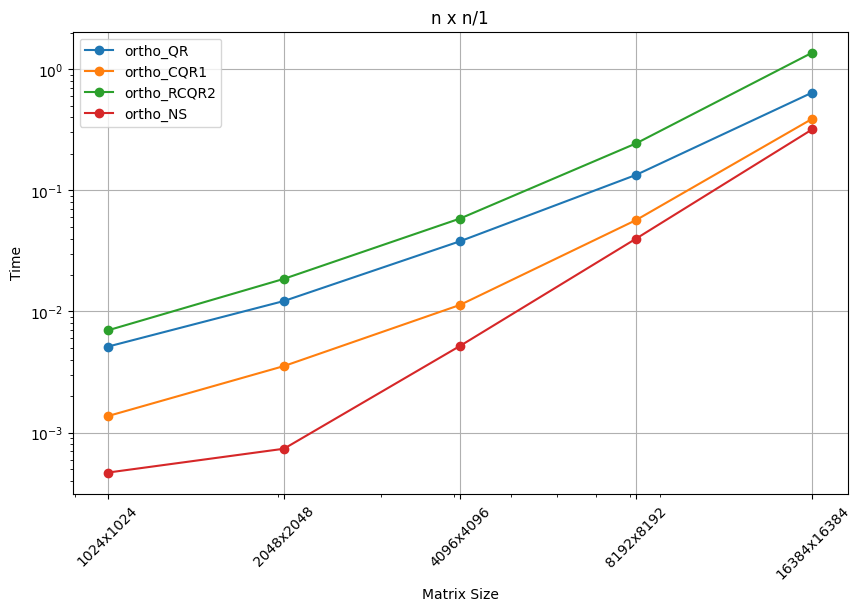

100%|██████████| 5/5 [00:31<00:00,  6.35s/it]


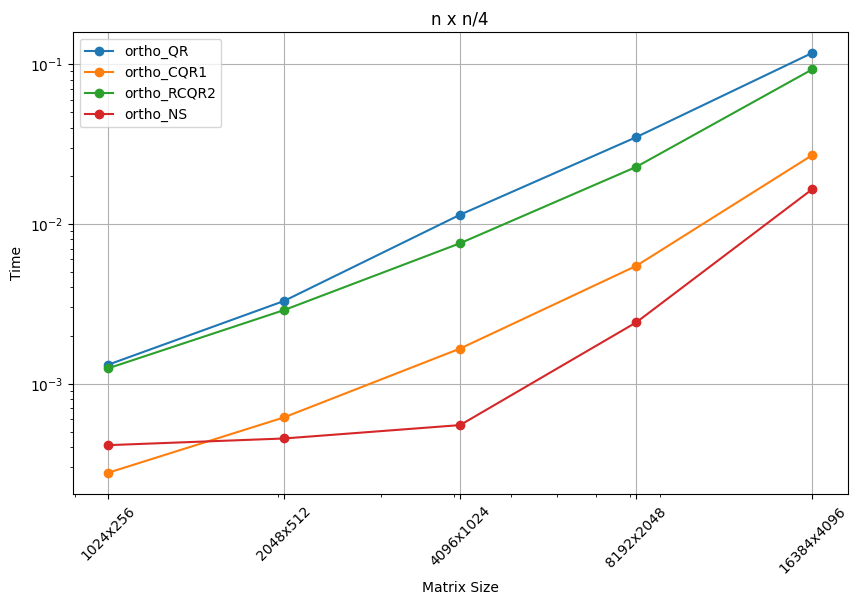

100%|██████████| 5/5 [00:30<00:00,  6.12s/it]


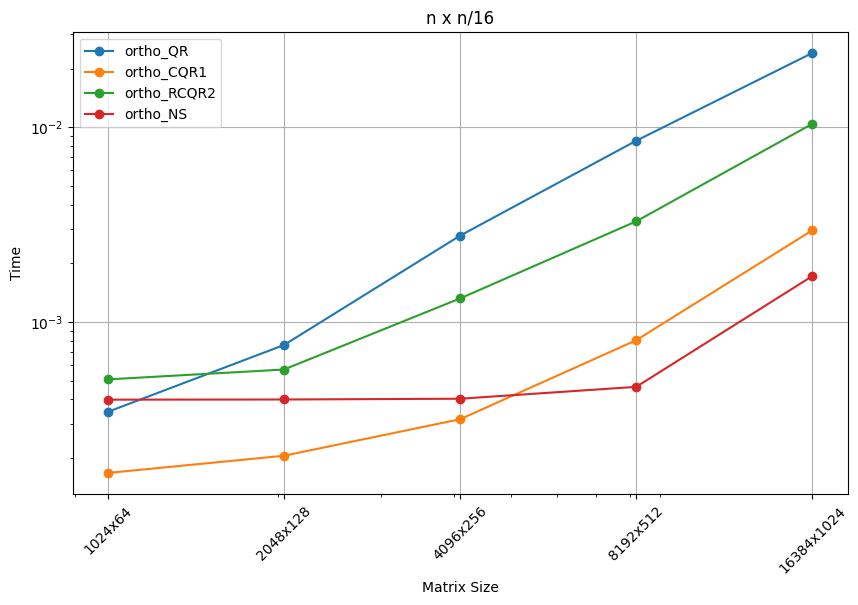

In [6]:
print(f"Using device: {torch.get_default_device()}")
base_dim = [1024, 2048, 4096, 8192, 16384]
benchmark_and_plot(base_dim, sparsity_ratio=1)
benchmark_and_plot(base_dim, sparsity_ratio=4)
benchmark_and_plot(base_dim, sparsity_ratio=16)

In [ ]:
def benchmark_actual_shapes(
    model_dims: list[int], mlp_expansion: int, sparsity_ratio: int, tp_dim: int
):
    ns_matrix_dims = [(mlp_expansion * d, d) for d in model_dims]
    qr_matrix_dims = [(mlp_expansion * d, d // sparsity_ratio) for d in model_dims]
    cqr_matrix_dims = [
        (mlp_expansion * d // tp_dim, d // sparsity_ratio) for d in model_dims
    ]

    results_ns = benchmark(["ortho_NS"], ns_matrix_dims)
    results_qr = benchmark(["ortho_QR"], qr_matrix_dims)
    results_cqr = benchmark(["ortho_CQR1"], cqr_matrix_dims)
    results_rcqr = benchmark(["ortho_RCQR2"], cqr_matrix_dims)
    results = {**results_ns, **results_qr, **results_cqr, **results_rcqr}

    # print the calculated matrix shapes
    print(
        "                            NS shape             QR shape             CQR shape"
    )
    for i, dim in enumerate(model_dims):
        ns_shape = str(ns_matrix_dims[i])
        qr_shape = str(qr_matrix_dims[i])
        cqr_shape = str(cqr_matrix_dims[i])
        print(f"Model dim {dim:5}: {ns_shape:>20} {qr_shape:>20} {cqr_shape:>20}")

    plt.figure(figsize=(10, 6))
    for func, times in results.items():
        plt.plot(model_dims, times, label=func, marker="o")

    plt.xscale("log")
    plt.yscale("log")
    plt.xticks(model_dims, [str(d) for d in model_dims])
    plt.xlabel("Model dimension")
    plt.ylabel("Time")
    plt.title(f"{mlp_expansion}n x n matrix, sparsity 1/{sparsity_ratio}, TP {tp_dim}")
    plt.legend()
    plt.grid()
    plt.show()

100%|██████████| 5/5 [00:16<00:00,  3.30s/it]

                            NS shape             QR shape             CQR shape
Model dim  1024:         (1024, 1024)           (1024, 64)            (128, 64)
Model dim  2048:         (2048, 2048)          (2048, 128)           (256, 128)
Model dim  4096:         (4096, 4096)          (4096, 256)           (512, 256)
Model dim  8192:         (8192, 8192)          (8192, 512)          (1024, 512)
Model dim 16384:       (16384, 16384)        (16384, 1024)         (2048, 1024)


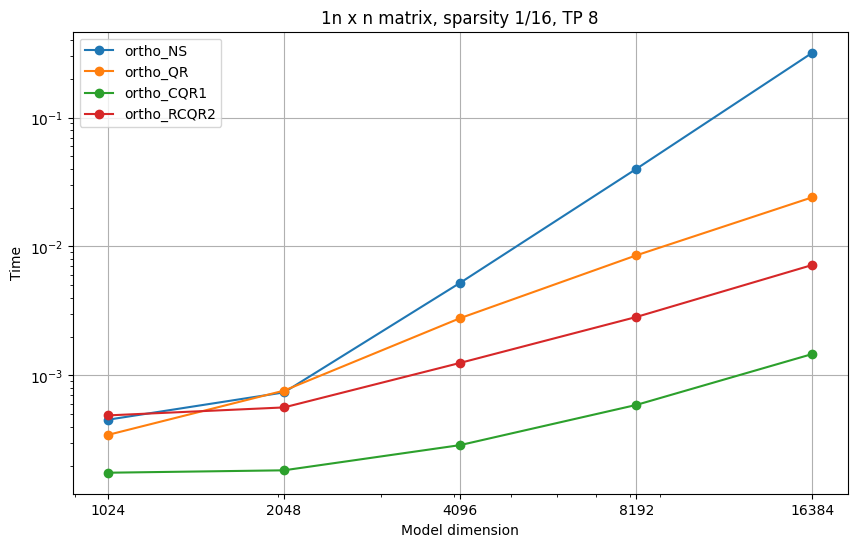

In [8]:
# Llama 8B      4096
# Gemma 27B     5376
# Deepseek 671B 7168
# Llama 70B     8192
# Llama 405B    16384
model_dims = [1024, 2048, 4096, 8192, 16384]
benchmark_actual_shapes(model_dims, mlp_expansion=1, sparsity_ratio=16, tp_dim=8)

100%|██████████| 5/5 [00:07<00:00,  1.45s/it]


                            NS shape             QR shape             CQR shape
Model dim  1024:         (4096, 1024)          (4096, 256)          (4096, 256)
Model dim  2048:         (8192, 2048)          (8192, 512)          (8192, 512)
Model dim  4096:        (16384, 4096)        (16384, 1024)        (16384, 1024)
Model dim  8192:        (32768, 8192)        (32768, 2048)        (32768, 2048)
Model dim 16384:       (65536, 16384)        (65536, 4096)        (65536, 4096)


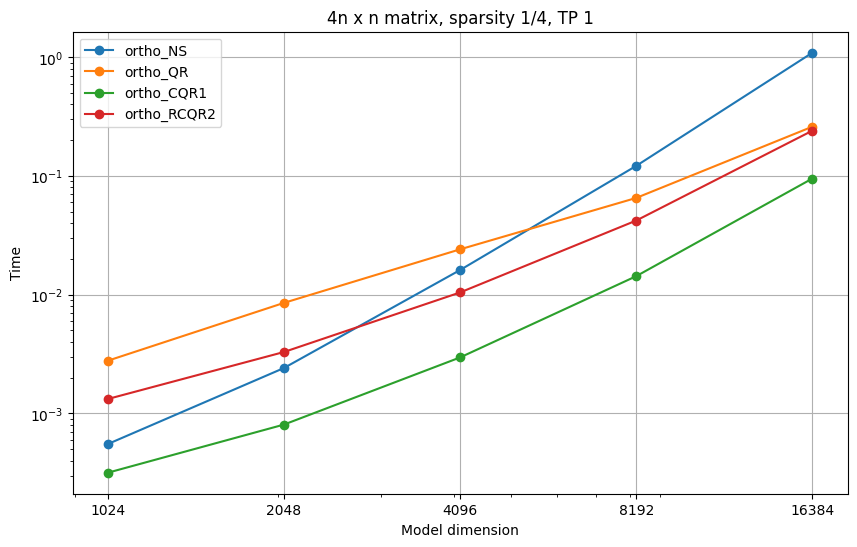

100%|██████████| 5/5 [00:17<00:00,  3.48s/it]

                            NS shape             QR shape             CQR shape
Model dim  1024:         (4096, 1024)           (4096, 64)           (4096, 64)
Model dim  2048:         (8192, 2048)          (8192, 128)          (8192, 128)
Model dim  4096:        (16384, 4096)         (16384, 256)         (16384, 256)
Model dim  8192:        (32768, 8192)         (32768, 512)         (32768, 512)
Model dim 16384:       (65536, 16384)        (65536, 1024)        (65536, 1024)


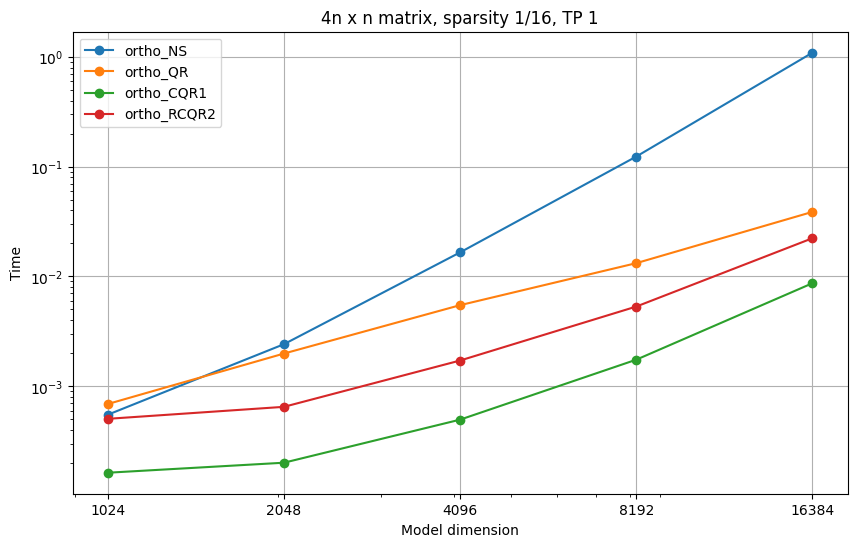

100%|██████████| 5/5 [00:08<00:00,  1.70s/it]

                            NS shape             QR shape             CQR shape
Model dim  1024:         (4096, 1024)          (4096, 256)           (512, 256)
Model dim  2048:         (8192, 2048)          (8192, 512)          (1024, 512)
Model dim  4096:        (16384, 4096)        (16384, 1024)         (2048, 1024)
Model dim  8192:        (32768, 8192)        (32768, 2048)         (4096, 2048)
Model dim 16384:       (65536, 16384)        (65536, 4096)         (8192, 4096)


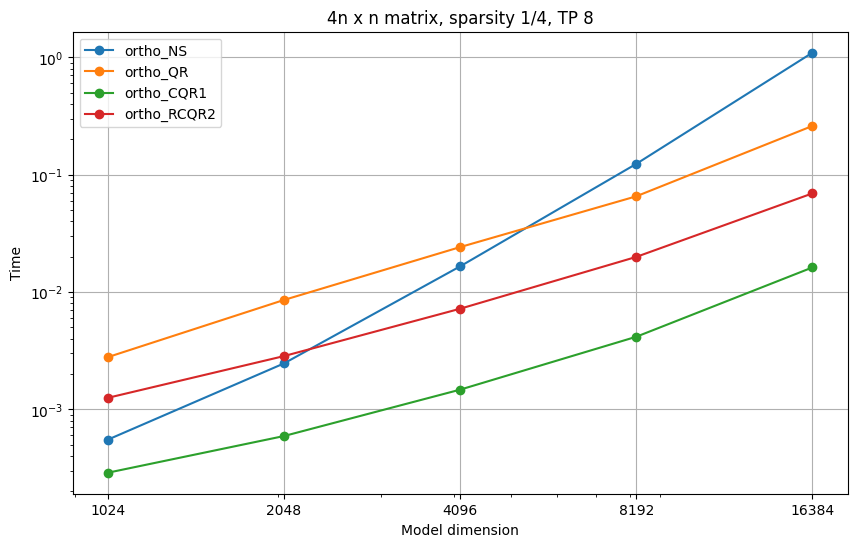

100%|██████████| 5/5 [00:09<00:00,  1.83s/it]

                            NS shape             QR shape             CQR shape
Model dim  1024:         (4096, 1024)           (4096, 64)            (512, 64)
Model dim  2048:         (8192, 2048)          (8192, 128)          (1024, 128)
Model dim  4096:        (16384, 4096)         (16384, 256)          (2048, 256)
Model dim  8192:        (32768, 8192)         (32768, 512)          (4096, 512)
Model dim 16384:       (65536, 16384)        (65536, 1024)         (8192, 1024)


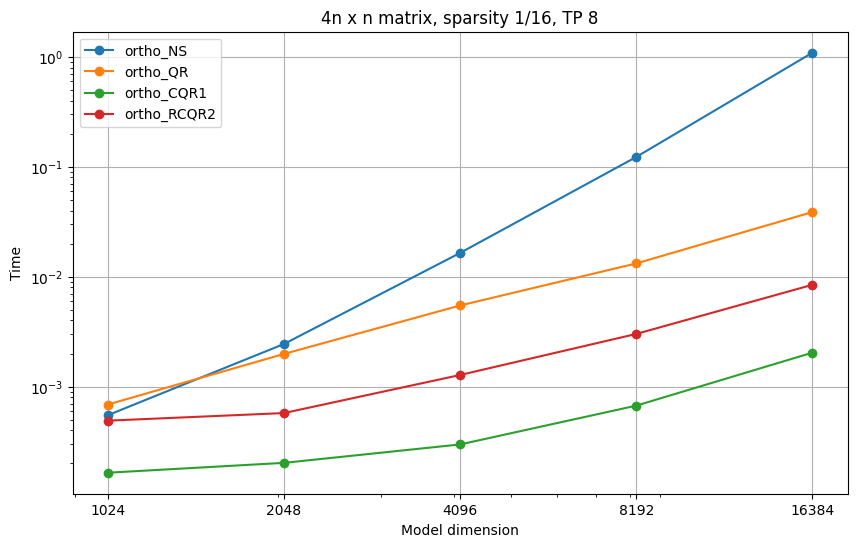

In [9]:
benchmark_actual_shapes(model_dims, mlp_expansion=4, sparsity_ratio=4, tp_dim=1)
benchmark_actual_shapes(model_dims, mlp_expansion=4, sparsity_ratio=16, tp_dim=1)
benchmark_actual_shapes(model_dims, mlp_expansion=4, sparsity_ratio=4, tp_dim=8)
benchmark_actual_shapes(model_dims, mlp_expansion=4, sparsity_ratio=16, tp_dim=8)

 60%|██████    | 3/5 [00:05<00:04,  2.02s/it]/home/byronxu/fast-opt/venv/lib/python3.10/site-packages/torch/_inductor/compile_fx.py:194: UserWarning: TensorFloat32 tensor cores for float32 matrix multiplication available but not enabled. Consider setting `torch.set_float32_matmul_precision('high')` for better performance.
  warnings.warn(
100%|██████████| 5/5 [00:15<00:00,  3.02s/it]


                            NS shape             QR shape             CQR shape
Model dim  1024:         (4096, 1024)         (4096, 1024)         (4096, 1024)
Model dim  2048:         (8192, 2048)         (8192, 2048)         (8192, 2048)
Model dim  4096:        (16384, 4096)        (16384, 4096)        (16384, 4096)
Model dim  8192:        (32768, 8192)        (32768, 8192)        (32768, 8192)
Model dim 16384:       (65536, 16384)       (65536, 16384)       (65536, 16384)


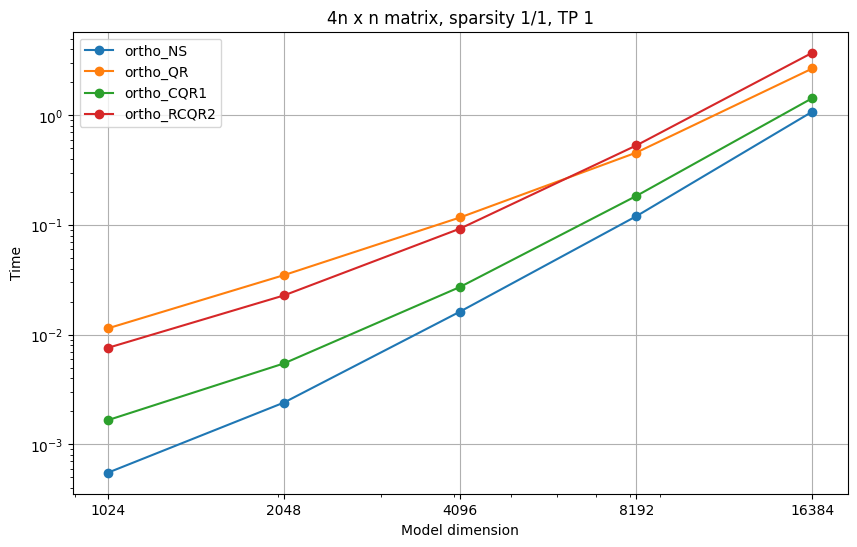

100%|██████████| 5/5 [00:09<00:00,  1.88s/it]

                            NS shape             QR shape             CQR shape
Model dim  1024:         (4096, 1024)         (4096, 1024)          (512, 1024)
Model dim  2048:         (8192, 2048)         (8192, 2048)         (1024, 2048)
Model dim  4096:        (16384, 4096)        (16384, 4096)         (2048, 4096)
Model dim  8192:        (32768, 8192)        (32768, 8192)         (4096, 8192)
Model dim 16384:       (65536, 16384)       (65536, 16384)        (8192, 16384)


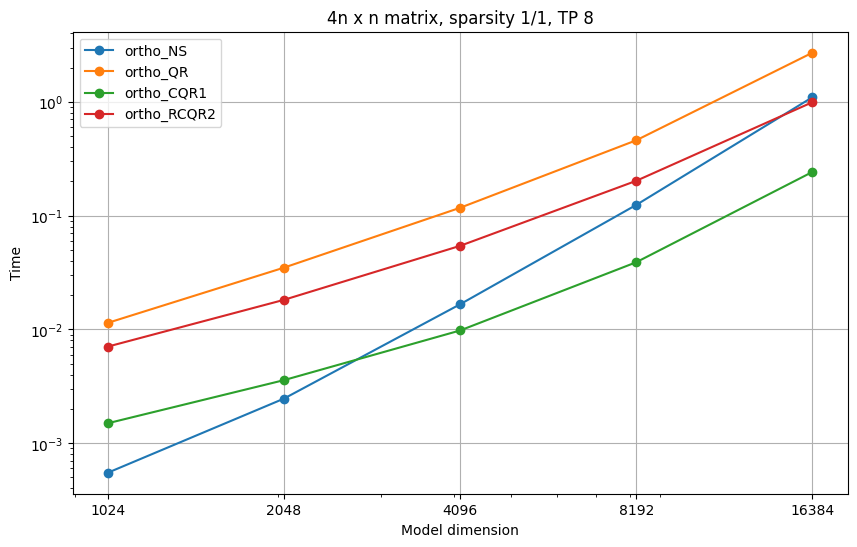

In [10]:
benchmark_actual_shapes(model_dims, mlp_expansion=4, sparsity_ratio=1, tp_dim=1)
benchmark_actual_shapes(model_dims, mlp_expansion=4, sparsity_ratio=1, tp_dim=8)

100%|██████████| 5/5 [00:07<00:00,  1.49s/it]

                            NS shape             QR shape             CQR shape
Model dim  1024:         (4096, 1024)           (4096, 16)            (512, 16)
Model dim  2048:         (8192, 2048)           (8192, 32)           (1024, 32)
Model dim  4096:        (16384, 4096)          (16384, 64)           (2048, 64)
Model dim  8192:        (32768, 8192)         (32768, 128)          (4096, 128)
Model dim 16384:       (65536, 16384)         (65536, 256)          (8192, 256)


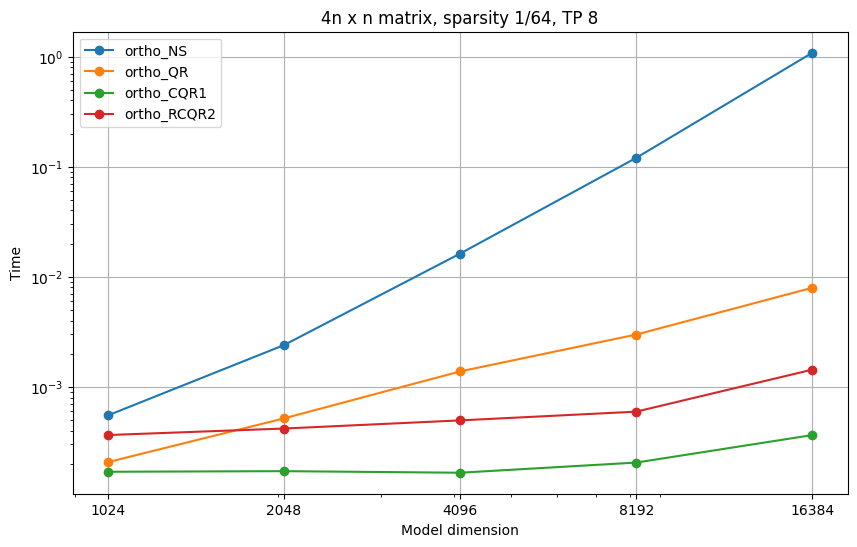

In [11]:
benchmark_actual_shapes(model_dims, mlp_expansion=4, sparsity_ratio=64, tp_dim=8)